# VAE for audio generation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import os
import librosa
import numpy as np
import librosa

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

from torchinfo import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Utils

In [3]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

## Dataset

In [4]:
from torchaudio.datasets import SPEECHCOMMANDS

#Class for dataset initialization imported from pytorch website
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("../dataset/", download=True,url="speech_commands_v0.02")

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

Sample rate of waveform: 16000
Label of waveform: backward
Speaker_id of waveform: 14c7b073
Utterance number of waveform: 4


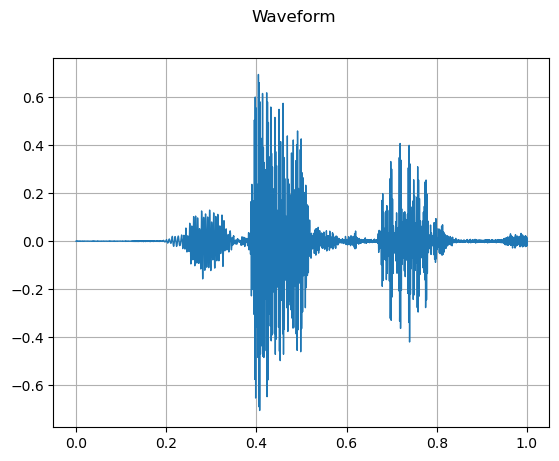

torch.Size([1, 16000])


In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[100]


print("Sample rate of waveform: {}".format(sample_rate))
print("Label of waveform: {}".format(label))
print("Speaker_id of waveform: {}".format(speaker_id))
print("Utterance number of waveform: {}".format(utterance_number))
plot_waveform(waveform,sample_rate)

ipd.Audio(waveform.numpy(),rate=sample_rate)
print(waveform.shape)

torch.Size([1, 64, 1601])


/home/joe/miniconda3/lib/python3.10/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


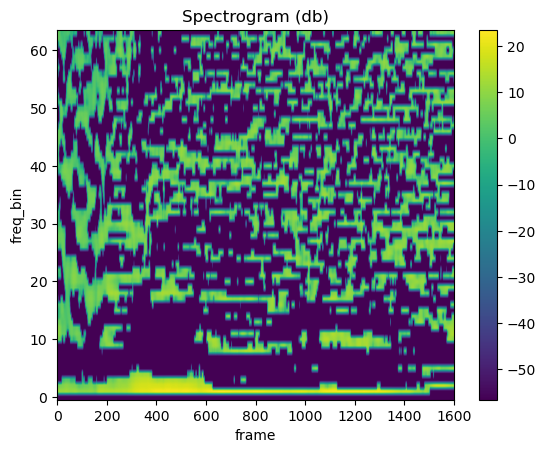

In [6]:
def downsample(audio_tensor,new_sample_rate=8000):
    return T.Resample(sample_rate,new_sample_rate,dtype=audio_tensor.dtype)(audio_tensor)

def mfcc_transform(audio_tensor,sample_rate,n_fft=512,n_mfcc=64,hop_length=10,mel_scale='htk'):
    transform = T.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={
            "hop_length": hop_length,
            "mel_scale": mel_scale,
            "n_fft": n_fft,
        },
    )
    return transform(audio_tensor.to(dtype=torch.float32))

#Change to noise waveform
mfcc = mfcc_transform(audio_tensor=waveform,sample_rate=16000)
print(mfcc.shape)
plot_spectrogram(mfcc.squeeze())

In [7]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    
    batch = [torch.squeeze(item).t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    
    return batch.unsqueeze(1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors= []

    # Gather in lists, and encode labels as indices
    # Add preprocessing
    for waveform, sample_rate, _, *_ in batch:
        tensors += [mfcc_transform(audio_tensor=waveform,sample_rate=16000)]
    
    tensors=pad_sequence(tensors)
   
    return tensors

In [8]:
batch_size = 256

if device == "cuda":
    num_workers = 14
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Model

In [9]:
from matchbox.ConvASREncoder import ConvASREncoder

class AudioVAE(nn.Module):
    def __init__(self,num_mels=64,input_length=1601,featureDim=128,zDim=96) -> None:
        super().__init__()
        self.encoder=ConvASREncoder(feat_in = num_mels)
        self.input_length = torch.tensor(input_length)

        self.pooling = torch.nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()

        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encBatchnorm1 = nn.BatchNorm1d(zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)
        self.encBatchnorm2 = nn.BatchNorm1d(zDim)

        #create decoder
        self.decConv1 = nn.ConvTranspose2d(1, 4, (9,200))
        self.decBatchnorm1 = nn.BatchNorm2d(4)
        self.decConv2 = nn.ConvTranspose2d(4, 4, (9,201))
        self.decBatchnorm2 = nn.BatchNorm2d(4)
        self.decConv3 = nn.ConvTranspose2d(4, 2, (9,201))
        self.decBatchnorm3 = nn.BatchNorm2d(2)
        self.decConv4 = nn.ConvTranspose2d(2, 1, (9,201))



    def reparameterize(self, mu, logVar):
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def encode(self,x):
        x=self.encoder(audio_signal=x,length=self.input_length)
        #x=self.flatten(x[0])
        #print(x[0].shape)
        batch, in_channels, timesteps = x[0].size()
        x=self.pooling(x[0]).view(batch, in_channels)
        #print(x.shape)
        mu=self.encBatchnorm1(F.relu(self.encFC1(x)))
        logVar=self.encBatchnorm2(F.relu(self.encFC2(x)))
        #print(logVar.shape)
        return mu,logVar
    
    def decode(self,x):
        #print(x.shape)
        x=x.unsqueeze(-1).unsqueeze(1)
        
        x=self.decConv1(x)
        x=self.decBatchnorm1(F.relu(x))
        x=self.decConv2(x)
        x=self.decBatchnorm2(F.relu(x))
        x=self.decConv3(x)
        x=self.decBatchnorm3(F.relu(x))
        x=self.decConv4(x)
        
        x=x.squeeze().view([-1,64,1600])
        x = torch.nn.functional.pad(input=x,pad=[0,1],mode='constant', value=0)
        #print(x.shape)
        return x.permute(0,2,1)

    def forward(self,x):
        #out=self.encode(x)
        #print(out.shape)
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        out = self.decode(z)
        return out, mu, logVar
    

In [10]:
class AudioVAE2(nn.Module):
    def __init__(self,num_mels=64,input_length=1601,featureDim=320,zDim=96) -> None:
        super().__init__()

        #encoder
        self.encConv1= nn.Conv1d(64,32,400)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.encConv2= nn.Conv1d(32,16,400)
        self.batchnorm2 = nn.BatchNorm1d(16)
        self.encConv3= nn.Conv1d(16,8,400)
        self.batchnorm3 = nn.BatchNorm1d(8)

        self.pooling= nn.MaxPool1d(10,return_indices=True)
        self.flatten= nn.Flatten()

        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        #decoder
        self.decFC1 = nn.Linear(zDim,featureDim)

        self.unpool= nn.MaxUnpool1d(10)
        self.batchnorm4 = nn.BatchNorm1d(8)
        self.decConv1 = nn.ConvTranspose1d(8, 16, 400)
        self.batchnorm5 = nn.BatchNorm1d(16)
        self.decConv2 = nn.ConvTranspose1d(16, 32, 400)
        self.batchnorm6 = nn.BatchNorm1d(32)
        self.decConv3 = nn.ConvTranspose1d(32, 64, 400)
      
        self.indices=0


    def reparameterize(self, mu, logVar):
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def encode(self,x):
        x=x.permute(0,2,1)
        #print(x.shape)
        x= F.relu(self.batchnorm1(self.encConv1(x)))
        #print(x.shape)
        x=F.relu(self.batchnorm2(self.encConv2(x)))
        #print(x.shape)
        x=F.relu(self.batchnorm3(self.encConv3(x)))
        #print(x.shape)
        x,self.indices=self.pooling(x)
        #print(x.shape)
        x=self.flatten(x)
        #print(x.shape)

        mu=self.encFC1(x)
        logVar=self.encFC2(x)
        #print(logVar.shape)
        return mu,logVar
    
    def decode(self,x):
        x=F.relu(self.decFC1(x))
        x=x.view([-1,8,40])
        x=self.unpool(x,self.indices)
        x=self.batchnorm4(x)
        x=F.relu(self.batchnorm5(self.decConv1(x)))
        x=F.relu(self.batchnorm6(self.decConv2(x)))
        x=F.relu(self.decConv3(x))
        #print(x.shape)
        
        x = torch.nn.functional.pad(input=x,pad=[0,4],mode='constant', value=0)
        #print(x.shape)
        return x.permute(0,2,1)

    def forward(self,x):
        #out=self.encode(x)
        #print(out.shape)
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        out = self.decode(z)
        return out, mu, logVar


In [11]:
model = AudioVAE2()
#For parallel gpus
#model = nn.DataParallel(model)
model.to(device)
summary(model)

Layer (type:depth-idx)                   Param #
AudioVAE2                                --
├─Conv1d: 1-1                            819,232
├─BatchNorm1d: 1-2                       64
├─Conv1d: 1-3                            204,816
├─BatchNorm1d: 1-4                       32
├─Conv1d: 1-5                            51,208
├─BatchNorm1d: 1-6                       16
├─MaxPool1d: 1-7                         --
├─Flatten: 1-8                           --
├─Linear: 1-9                            30,816
├─Linear: 1-10                           30,816
├─Linear: 1-11                           31,040
├─MaxUnpool1d: 1-12                      --
├─BatchNorm1d: 1-13                      16
├─ConvTranspose1d: 1-14                  51,216
├─BatchNorm1d: 1-15                      32
├─ConvTranspose1d: 1-16                  204,832
├─BatchNorm1d: 1-17                      64
├─ConvTranspose1d: 1-18                  819,264
Total params: 2,243,464
Trainable params: 2,243,464
Non-trainable params: 0

## Training

In [12]:
learning_rate = 1e-3
num_epochs = 10

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    progress_bar=tqdm(train_loader, desc='Epoch {} Progress'.format(epoch))
    for idx, data in enumerate(progress_bar, 0):
        imgs = data.squeeze()
        
        imgs = imgs.to(device)
        
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = model(imgs)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_div = 0.6 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        reconst_loss = F.mse_loss(out, imgs)
        loss = reconst_loss + kl_div

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        progress_bar.set_description ("Epoch {} Progress, Reconst Loss: {}, KL Div: {}".format( epoch,reconst_loss.item()/batch_size, kl_div.item()/batch_size))


Epoch 0 Progress:   0%|          | 0/332 [00:00<?, ?it/s]/home/joe/miniconda3/lib/python3.10/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
Epoch 0 Progress, Reconst Loss: 10.855663299560547, KL Div: 22.760868072509766:   2%|▏         | 7/332 [00:18<14:00,  2.59s/it]


KeyboardInterrupt: 

## Testing

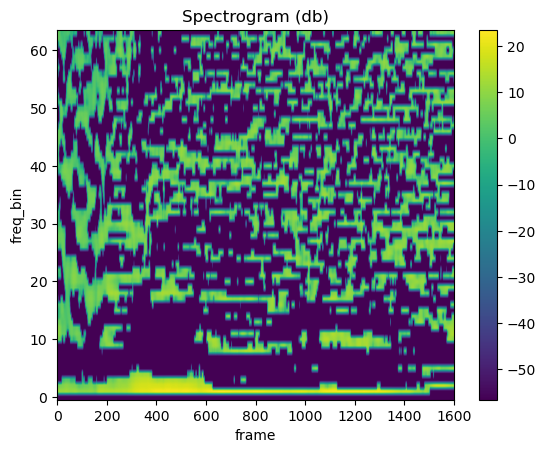

torch.Size([1, 1601, 64])


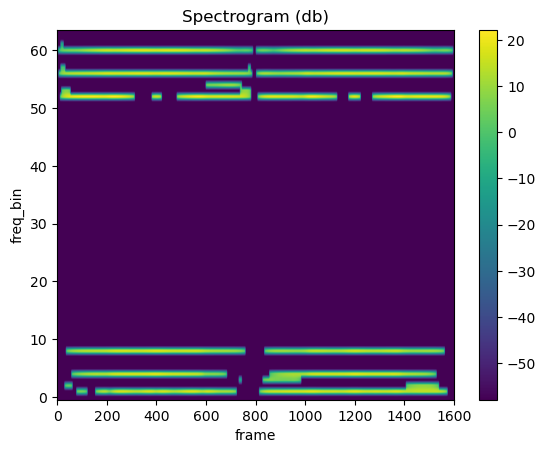

In [ ]:
model.eval()
plot_spectrogram(mfcc.squeeze())
with torch.no_grad():
    result=model(mfcc.permute(0,2,1).to(device))
    plot_spectrogram(result[0].permute(0,2,1).cpu().squeeze())

torch.Size([64, 1601])


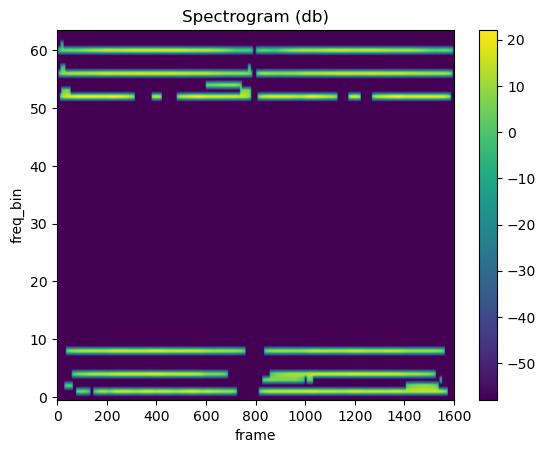

In [ ]:
def generate_random(model):
    model.eval()
    with torch.no_grad():
        z = torch.randn(128,96).to(device)
        out = model.decode(z)
    
    plot=out.cpu()[0].permute(1,0)

    print(plot.shape)
    plot_spectrogram(plot.numpy())
    return ipd.Audio(librosa.feature.inverse.mfcc_to_audio(plot.numpy(),n_mels=64,n_fft=512,sr=16000,hop_length=10,htk=True),rate=16000)#figure out the number of mels 
#audio_tensor,sample_rate,n_fft=512,n_mfcc=64,hop_length=10,mel_scale='htk'):
generate_random(model)